In [11]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt 
import torch 
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config,get_ds,train_the_config,get_ds_without_shuffling_on_train_set
from plotting.plotting import error_per_station_calendar_pattern
from examples.train_model_on_k_fold_validation import load_configuration
from constants.paths import SAVE_DIRECTORY
from high_level_DL_method import load_model,load_optimizer_and_scheduler
from examples.load_best_config import load_args_of_a_specific_trial
from trainer import Trainer
from plotting.plotting import get_gain_from_mod1,get_y_size_from_temporal_agg,plot_coverage_matshow,get_df_mase_and_gains,gain_between_models

def get_previous_and_prediction(trainer1,trainer2,ds1,ds2,training_mode):
    full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
    full_predict2,_,_ = trainer2.testing(ds2.normalizer, training_mode =training_mode)

    inputs = [[x,y,x_c] for  x,y,x_c in ds1.dataloader[training_mode]]
    X = torch.cat([x for x,_,_ in inputs],0)
    X = ds1.normalizer.unormalize_tensor(inputs = X,feature_vect = True) # unormalize input cause prediction is unormalized 

    previous = X[:,:,-1]
    predict1 = full_predict1[:,:,0]
    predict2 = full_predict2[:,:,0]
    real = Y_true[:,:,0]
    return previous,predict1,predict2,real

def plot_gain_between_models_with_temporal_agg(ds,dic_error,stations,temporal_aggs,training_mode):
    fig, axes = plt.subplots(len(temporal_aggs), 2, figsize=(max(8,0.5*len(stations)),6*len(temporal_aggs)),gridspec_kw={'width_ratios': [1,5],'height_ratios': [4,3,2]})
    for i,temporal_agg in enumerate(temporal_aggs):
        df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds,dic_error,training_mode,temporal_agg,stations)
        # agg All sations  
        plt.sca(axes[i,0])
        plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_gain21).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-10,v_max=10)
        title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1\nAggregated through stations'
        axes[i,0].set_title(title)

        # Per station 
        plt.sca(axes[i,1])
        plot_coverage_matshow(pd.DataFrame(df_gain21),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-20,v_max=20)
        title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1'
        axes[i,1].set_title(title) 

def get_trainer_and_ds_from_saved_trial(trial_id,add_name_id,save_folder,modification,fold_to_evaluate = None):
    # Load Data and Init Model:
    if fold_to_evaluate is None:
        fold_name = 'complete_dataset'
    else:
        fold_name = fold_to_evaluate[0]

    #args,_ = load_configuration(trial_id1,load_config=True)
    args = load_args_of_a_specific_trial(trial_id,add_name_id,save_folder,fold_name)

    if fold_to_evaluate is None:  fold_to_evaluate = [args.K_fold-1]

    
           
    ds,_,_,_,_ =  get_ds(args_init=args,modification = modification,fold_to_evaluate=fold_to_evaluate)
    model = load_model(ds, args)


    # Load Trained Weights 
    model_param = torch.load(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/best_models/{trial_id}{add_name_id}_f{fold_name}.pkl")
    model.load_state_dict(model_param['state_dict'],strict=True)


    # Load Trainer : 
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler)

    return trainer,ds,args


# Load Both models to compare : 

In [2]:
modification = {'shuffle':False,
                'data_augmentation':False }

# Load Model1:
save_folder1 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id1 = ''
trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trainer1,ds1,args1 = get_trainer_and_ds_from_saved_trial(trial_id1,add_name_id1,save_folder1,modification)

# Load Model2: 
#Trained Model with Subway-in / Subway-out 
if False:
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'concat_early'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

#Trained Model with Subway-in / NetMob POI:
if False: 
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    #add_name_id2 = 'NETMOB_POIS_maps_Twitter_concat_early_late_UL_DL_all_tags'
    add_name_id2 = 'NETMOB_POIS_maps_Deezer_concat_early_DL_IRIS'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 


Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713


## Have a look on some interpolation:

In [3]:
# 'DA_method': 'magnitude_warping'
# 'DA_method': 'rich_interpolation'
# 'DA_method': 'interpolation'

modification = {'shuffle':False,
                'DA_method' : ['magnitude_warping','rich_interpolation'],
                'data_augmentation' : True 
                }


save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
add_name_id2 = 'concat_early'
trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)

training_mode = 'train'
inputs = [[x,y,x_c] for  x,y,x_c in ds2.dataloader[training_mode]]
nb_contextual_data = len(inputs[0][2])
X = torch.cat([x for x,_,_ in inputs],0).to(trainer2.args.device)
Y_true = torch.cat([y for _,y,_ in inputs],0).to(trainer2.args.device)
X_c = [torch.cat([x_c[k] for _,_,x_c in inputs],0).to(trainer2.args.device)  for k in range(nb_contextual_data)]
X_c_one = [torch.ones(x_c.size()).to(trainer2.args.device) for x_c in X_c]

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776



Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
vision_input_type POIs
vision_model_name VariableSelectionNetwork
2821 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek data augmented by duplication but not modified
calendar_hour data augmented by duplication but not modified
calendar_dayofweek dat

<Axes: >

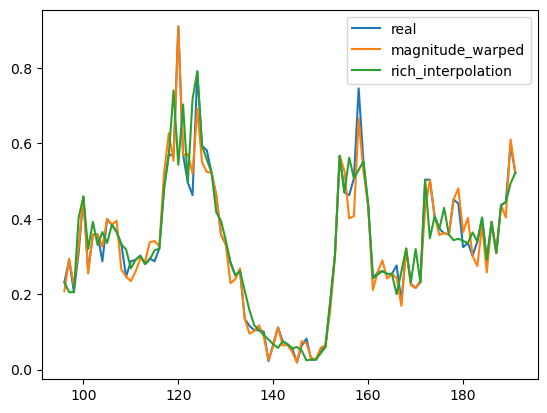

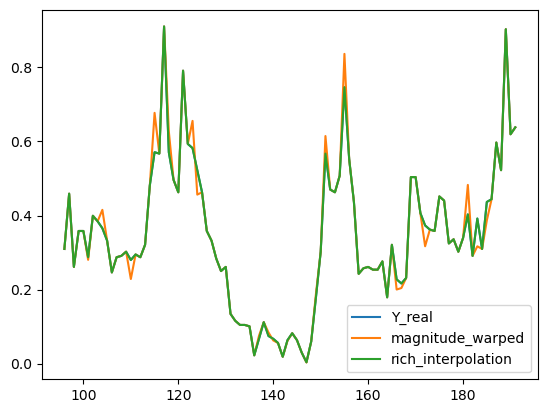

In [10]:
n = X.size(0)//3
station_i = 0

L = -3

pd.DataFrame({'real': X[:n,station_i,L].detach().cpu(),
              'magnitude_warped':X[n:2*n,station_i,L].detach().cpu(),
              'rich_interpolation':X[2*n:,station_i,L].detach().cpu(),
              }).iloc[96*1:96*2,:].plot()


pd.DataFrame({'Y_real': Y_true[:n,station_i,0].detach().cpu(),
              'magnitude_warped':Y_true[n:2*n,station_i,0].detach().cpu(),
               'rich_interpolation':Y_true[2*n:,station_i,0].detach().cpu(),
              }).iloc[96*1:96*2,:].plot()

## Get Metrics from trained model. Compared consistency with saved one : 
Nous permets de nous assurer qu'on à bien sauvegarder le meilleur model, et que c'est bien celui qu'on Load.

In [3]:
def display_consistency(trainer,ds,save_folder,trial_id,add_name_id,training_mode = 'test'):
    full_predict1,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
    Y_true= Y_true.detach().clone().reshape(-1)    
    full_predict1= full_predict1.detach().clone().reshape(-1)    
    error_pred1 = ((Y_true - full_predict1)**2).mean()

    df_metrics1 = pd.read_csv(f"{current_path}/{SAVE_DIRECTORY}/{save_folder}/METRICS_{trial_id}{add_name_id}.csv")
    display(df_metrics1)
    print(f"MSE errror on {training_mode} by loading trained model : {'{:.2f}'.format(error_pred1.item())}\n")

In [3]:
display_consistency(trainer1,ds1,save_folder1,trial_id1,add_name_id1,training_mode = 'test')
display_consistency(trainer2,ds2,save_folder2,trial_id2,add_name_id2,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1250.633032,20.827599,34.545302,8210.072104,0.396348,11.819149,1157.247070,19.905209,30.030531
1,test,1306.318921,21.229312,33.583765,1632.788441,0.561886,37.853172,1319.264526,20.539398,28.160223


MSE errror on test by loading trained model : 1319.26



,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1230.919019,20.847181,36.719215,5382.383880,0.558646,6.967195,1128.664185,19.996849,33.227039
1,test,1288.185107,21.260062,36.229020,4998.188979,1.045187,84.935830,1286.441650,20.617752,29.995420


MSE errror on test by loading trained model : 1286.44



## Checking if Contetual Data are taken into account
- Set the Tensor associated to contextual data as 0 Tensor 
- Do the prediction 
- Compare the associated metrics

In [9]:
def check_impact_of_contextual_data(trainer,ds,training_mode = 'test'):
    inputs = [[x,y,x_c] for  x,y,x_c in ds.dataloader[training_mode]]
    nb_contextual_data = len(inputs[0][2])
    X = torch.cat([x for x,_,_ in inputs],0).to(trainer.args.device)
    Y_true = torch.cat([y for _,y,_ in inputs],0).to(trainer.args.device)
    X_c = [torch.cat([x_c[k] for _,_,x_c in inputs],0).to(trainer.args.device)  for k in range(nb_contextual_data)]
    X_c_one = [torch.ones(x_c.size()).to(trainer.args.device) for x_c in X_c]

    trainer.model.eval()
    with torch.no_grad():
        Preds = trainer.model(X,X_c)
        Preds_no_contextual = trainer.model(X,X_c_one)
        
    Preds = Preds.detach().cpu()
    Preds_no_contextual = Preds_no_contextual.detach().cpu()
    Y_true = Y_true.detach().cpu()
    Preds = ds.normalizer.unormalize_tensor(inputs = Preds,feature_vect = True).reshape(-1)     #  device = self.args.device
    Preds_no_contextual = ds.normalizer.unormalize_tensor(inputs = Preds_no_contextual,feature_vect = True).reshape(-1)     #  device = self.args.device
    Y_true = ds.normalizer.unormalize_tensor(inputs = Y_true,feature_vect = True).reshape(-1)     # device = self.args.device

    error_pred1 = ((Y_true - Preds)**2).mean()
    error_pred_contextual_null = ((Y_true - Preds_no_contextual)**2).mean()

    print(f"MSE errror on {training_mode} set by loading trained model :\nWith contectual data: {'{:.2f}'.format(error_pred1.item())}")
    print(f"Without contectual data: {'{:.2f}'.format(error_pred_contextual_null.item())}")
    print(f"Associated MSE Gain {'{:.1%}'.format(1-error_pred1.item()/error_pred_contextual_null.item())}")

check_impact_of_contextual_data(trainer2,ds2,training_mode = 'test')

MSE errror on test set by loading trained model :
With contectual data: 1286.44
Without contectual data: 2206.18
Associated MSE Gain 41.7%


## Production de Visuel :

In [4]:
# Get Pred1,Pred2, TrueValues:
training_mode = 'test'
min_flow = 20

previous,predict1,predict2,real = get_previous_and_prediction(trainer1,trainer2,ds1,ds2,training_mode)
dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

## Get Naiv Error and Model1 Error: 

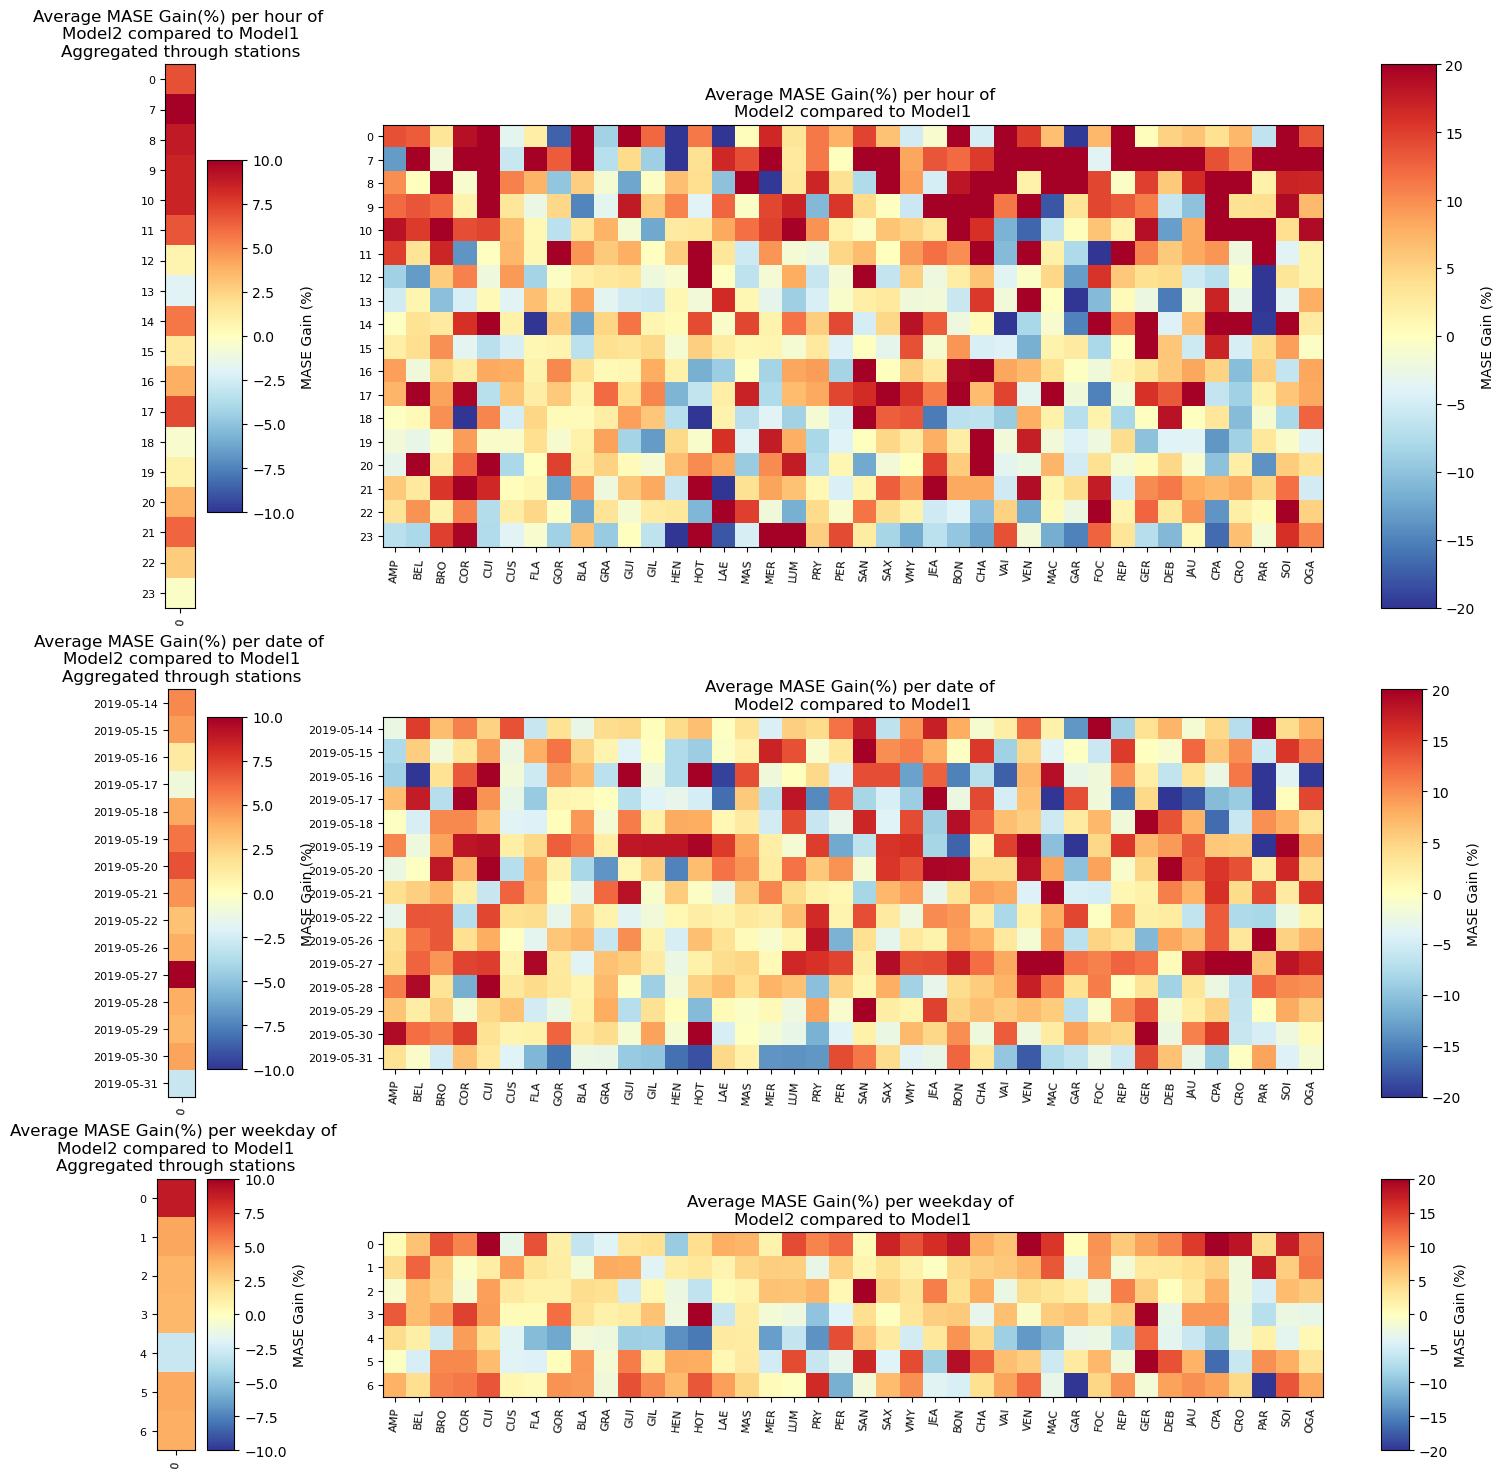

In [6]:
temporal_aggs = ['hour','date','weekday']
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)


plot_gain_between_models_with_temporal_agg(ds1,dic_error,stations,temporal_aggs,training_mode)

"""
fig, axes = plt.subplots(len(temporal_aggs), 2, figsize=(max(8,0.5*len(stations)),6*len(temporal_aggs)),gridspec_kw={'width_ratios': [1,5],'height_ratios': [4,3,2]})
for i,temporal_agg in enumerate(temporal_aggs):
    df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds1,dic_error,training_mode,temporal_agg,stations)
    # agg All sations  
    plt.sca(axes[i,0])
    plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_gain21).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-10,v_max=10)
    title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1\nAggregated through stations'
    axes[i,0].set_title(title)

    # Per station 
    plt.sca(axes[i,1])
    plot_coverage_matshow(pd.DataFrame(df_gain21),cmap = 'RdYlBu', save=None, 
                        cbar_label='MASE Gain (%)',bool_reversed=True,v_min=-20,v_max=20)
    title = f'Average MASE Gain(%) per {temporal_agg} of \nModel2 compared to Model1'
    axes[i,1].set_title(title) 
"""


## Plot Time Series on specific station: 

<Axes: >

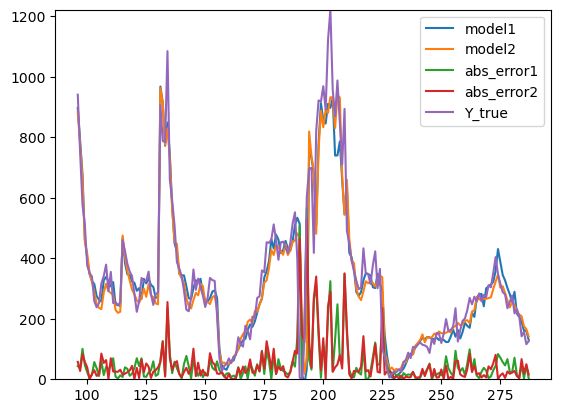

In [6]:
station = 'BEL'
start_day = 1
nb_days = 2


station_i = list(ds1.spatial_unit).index(station)
pred1 = predict1[:,station_i].numpy()
pred2 = predict2[:,station_i].numpy()
ytrue = real[:,station_i].numpy()

error_abs1 = dic_error['mae']['error_pred1'].reshape(-1,len(ds1.spatial_unit))[:,station_i]
error_abs2 = dic_error['mae']['error_pred2'].reshape(-1,len(ds1.spatial_unit))[:,station_i]
naive_error = dic_error['mae_naiv']['error_naiv'].reshape(-1,len(ds1.spatial_unit))[:,station_i]

ax = pd.DataFrame({'model1':pred1,
              'model2':pred2,
              'abs_error1':error_abs1,
              'abs_error2':error_abs2,
              'Y_true':ytrue 
              }).iloc[start_day*96:96*(start_day+nb_days)]
ax.plot(ylim = [0,ytrue[start_day*96:96*(start_day+nb_days)].max()])

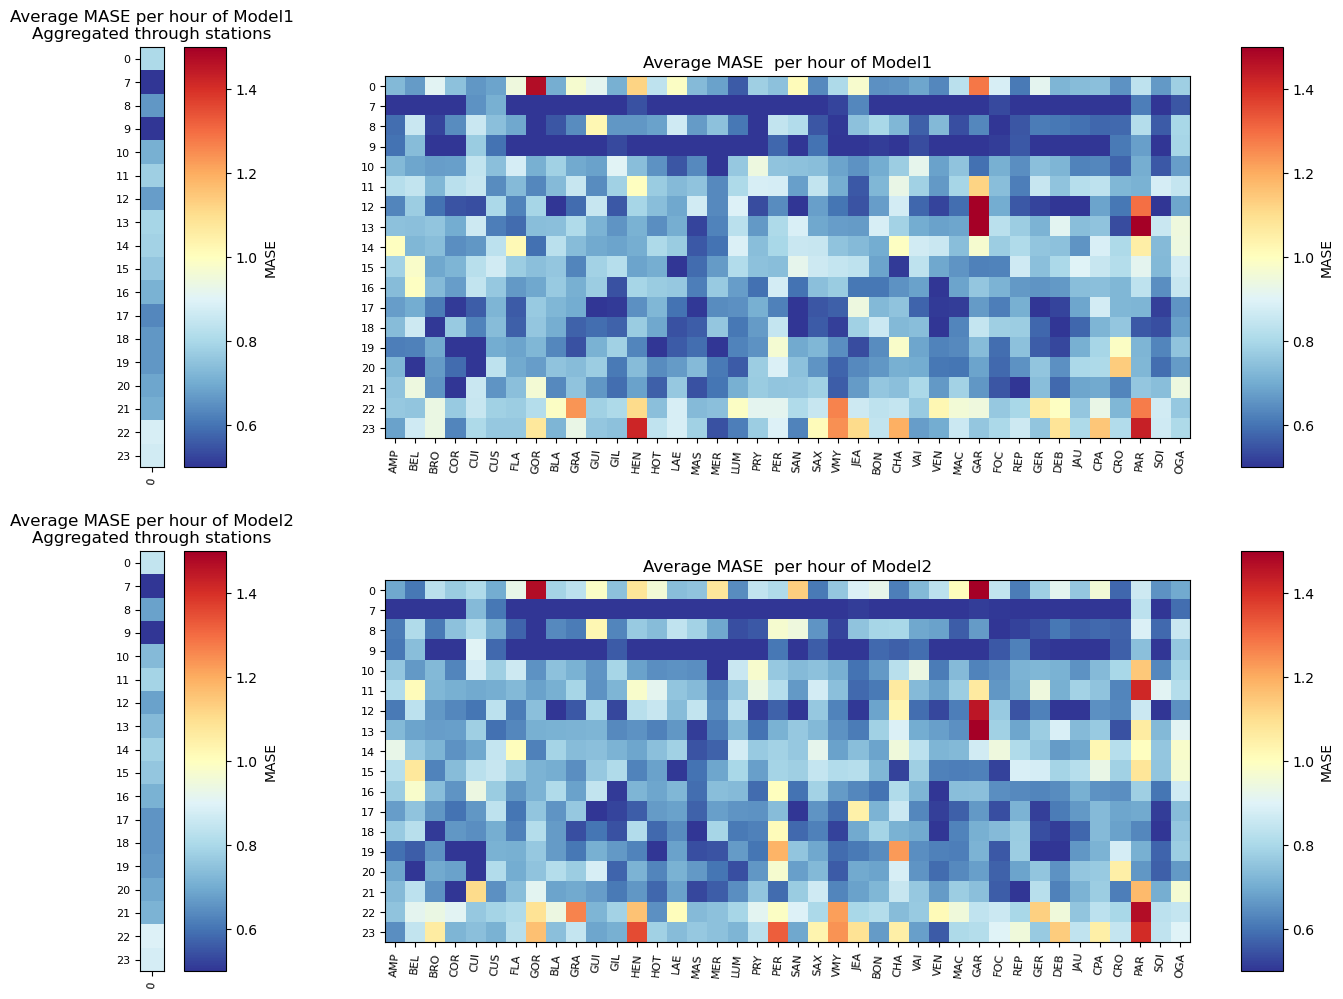

In [10]:
stations = list(ds1.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)
temporal_aggs = ['hour'] #['weekday_hour_minute','weekday_hour','hour','date','weekday']
for temporal_agg in temporal_aggs:
    fig, axes = plt.subplots(2, 2, figsize=(max(8,0.5*len(stations)),get_y_size_from_temporal_agg(temporal_agg)),gridspec_kw={'width_ratios': [2,5]})
    df_mase1,df_mase2,df_gain21 = get_df_mase_and_gains(ds1,dic_error,training_mode,temporal_agg,stations)
    for i,df_mase in enumerate([df_mase1,df_mase2]):
        # agg All sations  
        plt.sca(axes[i,0])
        plot_coverage_matshow(pd.DataFrame(pd.DataFrame(df_mase).mean(axis=1)),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
        title = f'Average MASE per {temporal_agg} of Model{i+1}\nAggregated through stations'
        axes[i,0].set_title(title)

        # Per station 
        plt.sca(axes[i,1])
        plot_coverage_matshow(pd.DataFrame(df_mase),cmap = 'RdYlBu', save=None, 
                            cbar_label='MASE',bool_reversed=True,v_min=0.5,v_max=1.5)
        title = f'Average MASE  per {temporal_agg} of Model{i+1}'
        axes[i,1].set_title(title) 


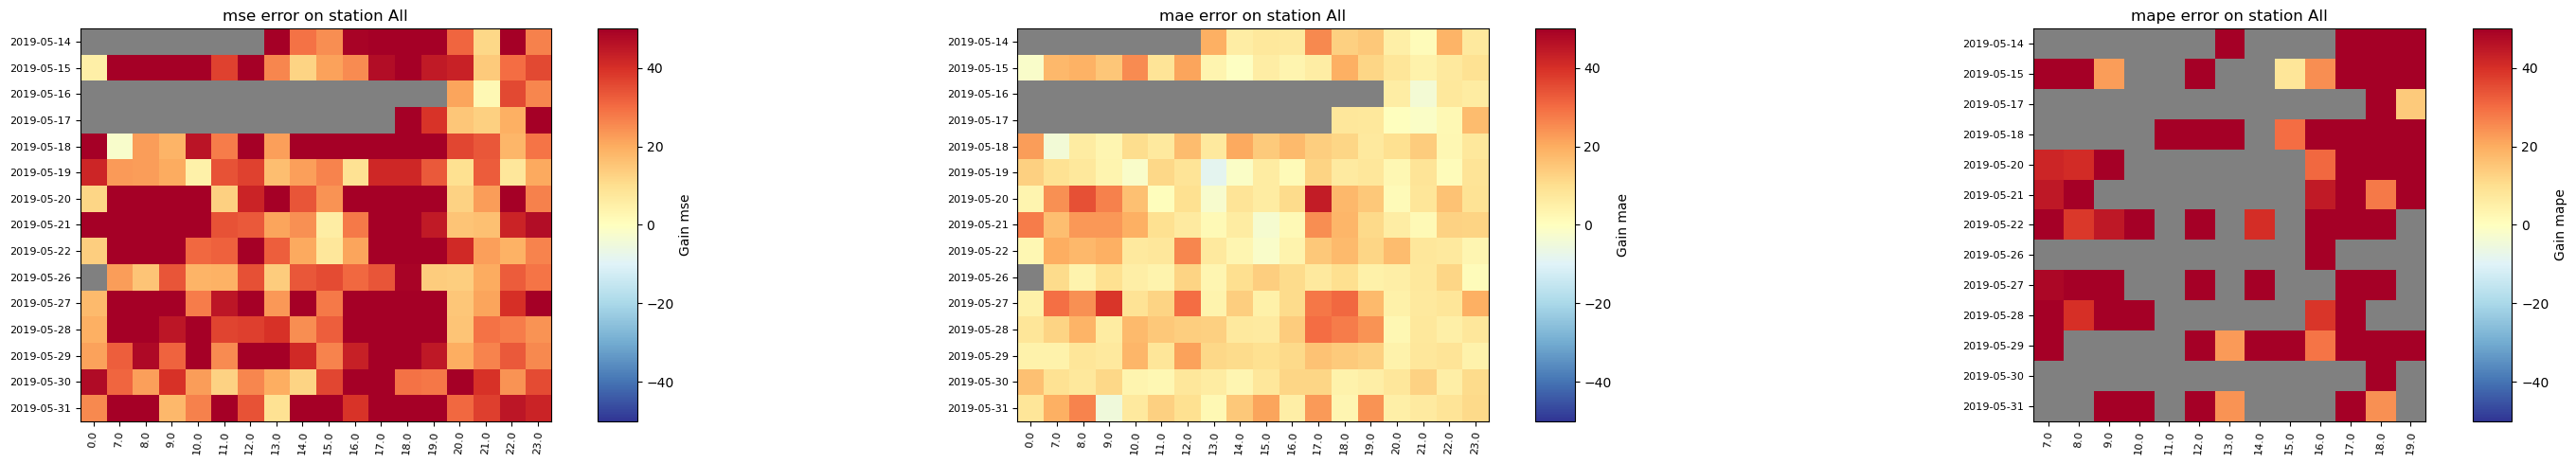

(<Figure size 3000x500 with 6 Axes>,
 array([<Axes: title={'center': 'mse error on station All'}>,
        <Axes: title={'center': 'mae error on station All'}>,
        <Axes: title={'center': 'mape error on station All'}>],
       dtype=object))

In [11]:
station = ['PAR','PER','GER','BON']
training_mode = 'test'

# index_matshow in :  ['weekday','hour','month_year','date','day_date']
# columns_matshow in :  [None, 'weekday','hour','month_year','date','day_date']

gain_between_models(trainer1,trainer2,ds1,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station,
                        plot_each_station = False,
                        plot_all_station = True)

## Visualisation des coeff d'attentions :

In [ ]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)
temporal_agg = 'hour'  # weekday_hour_minutes','hour','weekday','weekday_hour'
plot_attn_weight(trainer2,nb_calendar_data,ds1,training_mode = training_mode,stations= station,temporal_agg =temporal_agg,save=None)

## Fine Tuning on Specific Moments : 

In [2]:
modification = {'shuffle':False,
                'DA_method' : ['rich_interpolation'], #'magnitude_warping',
                'data_augmentation' : True,
                'DA_moment_to_focus' : [{'hours':[21,22,23],'weekdays':[0,1,2,3,4]}],
                'DA_magnitude_max_scale':0.1
                }


save_folder = 'K_fold_validation/training_with_HP_tuning/re_validation'

if False: 
    add_name_id = 'concat_early'
    trial_id ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 

if True:
    add_name_id = ''
    trial_id ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'

trainer,ds,args = get_trainer_and_ds_from_saved_trial(trial_id,add_name_id,save_folder,modification)

>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values


336 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([3493, 40, 7]) torch.Size([3493, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 3493 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
120 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([1299, 40, 7]) torch.Size([1299, 40, 1])
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1299 941 939

 ===== ERRO

In [4]:
display_consistency(trainer,ds,save_folder,trial_id,add_name_id,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1250.633032,20.827599,34.545302,8210.072104,0.396348,11.819149,1157.247070,19.905209,30.030531
1,test,1306.318921,21.229312,33.583765,1632.788441,0.561886,37.853172,1319.264526,20.539398,28.160223


MSE errror on test by loading trained model : 1319.26



## Fine Tuning on the augmmented dataset:

In [5]:
trainer.args.epochs = 10
trainer.train_and_valid()
trainer.performance


start training

Training Throughput:182.71 sequences per seconds
>>> Training complete in: 0:03:32.969261
>>> Training performance time: min 0.014125823974609375 avg 0.04370594024658203 seconds (+/- 0.24622445676360963)
>>> Loading performance time: min 0.00041222572326660156 avg 0.08261793657489445 seconds (+/- 1.387212618462245)
>>> Forward performance time: 0.11396939153558455 seconds (+/- 0.21587615912083835)
>>> Backward performance time: 0.011490416591876848 seconds (+/- 0.022487713321117757)
>>> Plotting performance time: 2.966986762152778e-06 seconds (+/- 9.343460977632946e-07)
>>> Saving performance time: 0.43316829204559326 seconds (+/- 0.4271758794784546)
>>> PI-tracking performance time: 1.0861290825737848e-05 seconds (+/- 8.485462122451743e-06)
>>> Scheduler-update performance time: 5.192226833767361e-06 seconds (+/- 2.951810259752087e-06)
>>> Peak Power during training: 88.959 W)
>>> Validation time: 0:00:00.503560
Proportion of time consumed for Loading: 34.8%
Proportio

{'valid_loss': 0.0025351704311299514,
 'valid_metrics': {'mse': 0.0025351704098284245,
  'mae': 0.03199104219675064,
  'mape': 30.287452697753906},
 'test_metrics': {'mse': 0.0031529576517641544,
  'mae': 0.03316894546151161,
  'mape': 27.91893196105957},
 'epoch': 6,
 'training_over': True,
 'fold': 'complete_dataset'}

<Axes: >

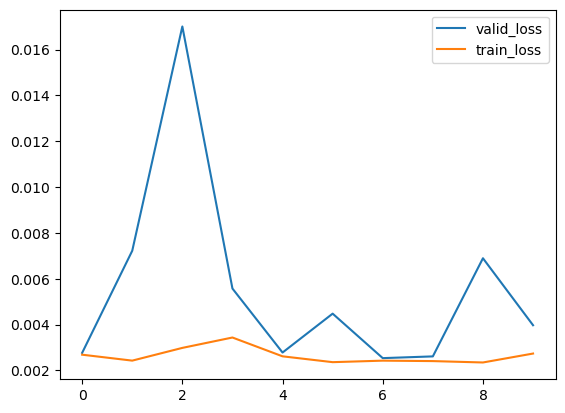

In [7]:
import pandas as pd
pd.DataFrame({'valid_loss': trainer.valid_loss,
              'train_loss': trainer.train_loss
              }).plot()

In [13]:
display_consistency(trainer,ds,save_folder,trial_id,add_name_id,training_mode = 'test')

,Unnamed: 0,mse,mae,mape,VAR_mse,VAR_mae,VAR_mape,mse_complete_ds,mae_complete_ds,mape_complete_ds
0,valid,1250.633032,20.827599,34.545302,8210.072104,0.396348,11.819149,1157.247070,19.905209,30.030531
1,test,1306.318921,21.229312,33.583765,1632.788441,0.561886,37.853172,1319.264526,20.539398,28.160223


MSE errror on test by loading trained model : 2276.99



>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713


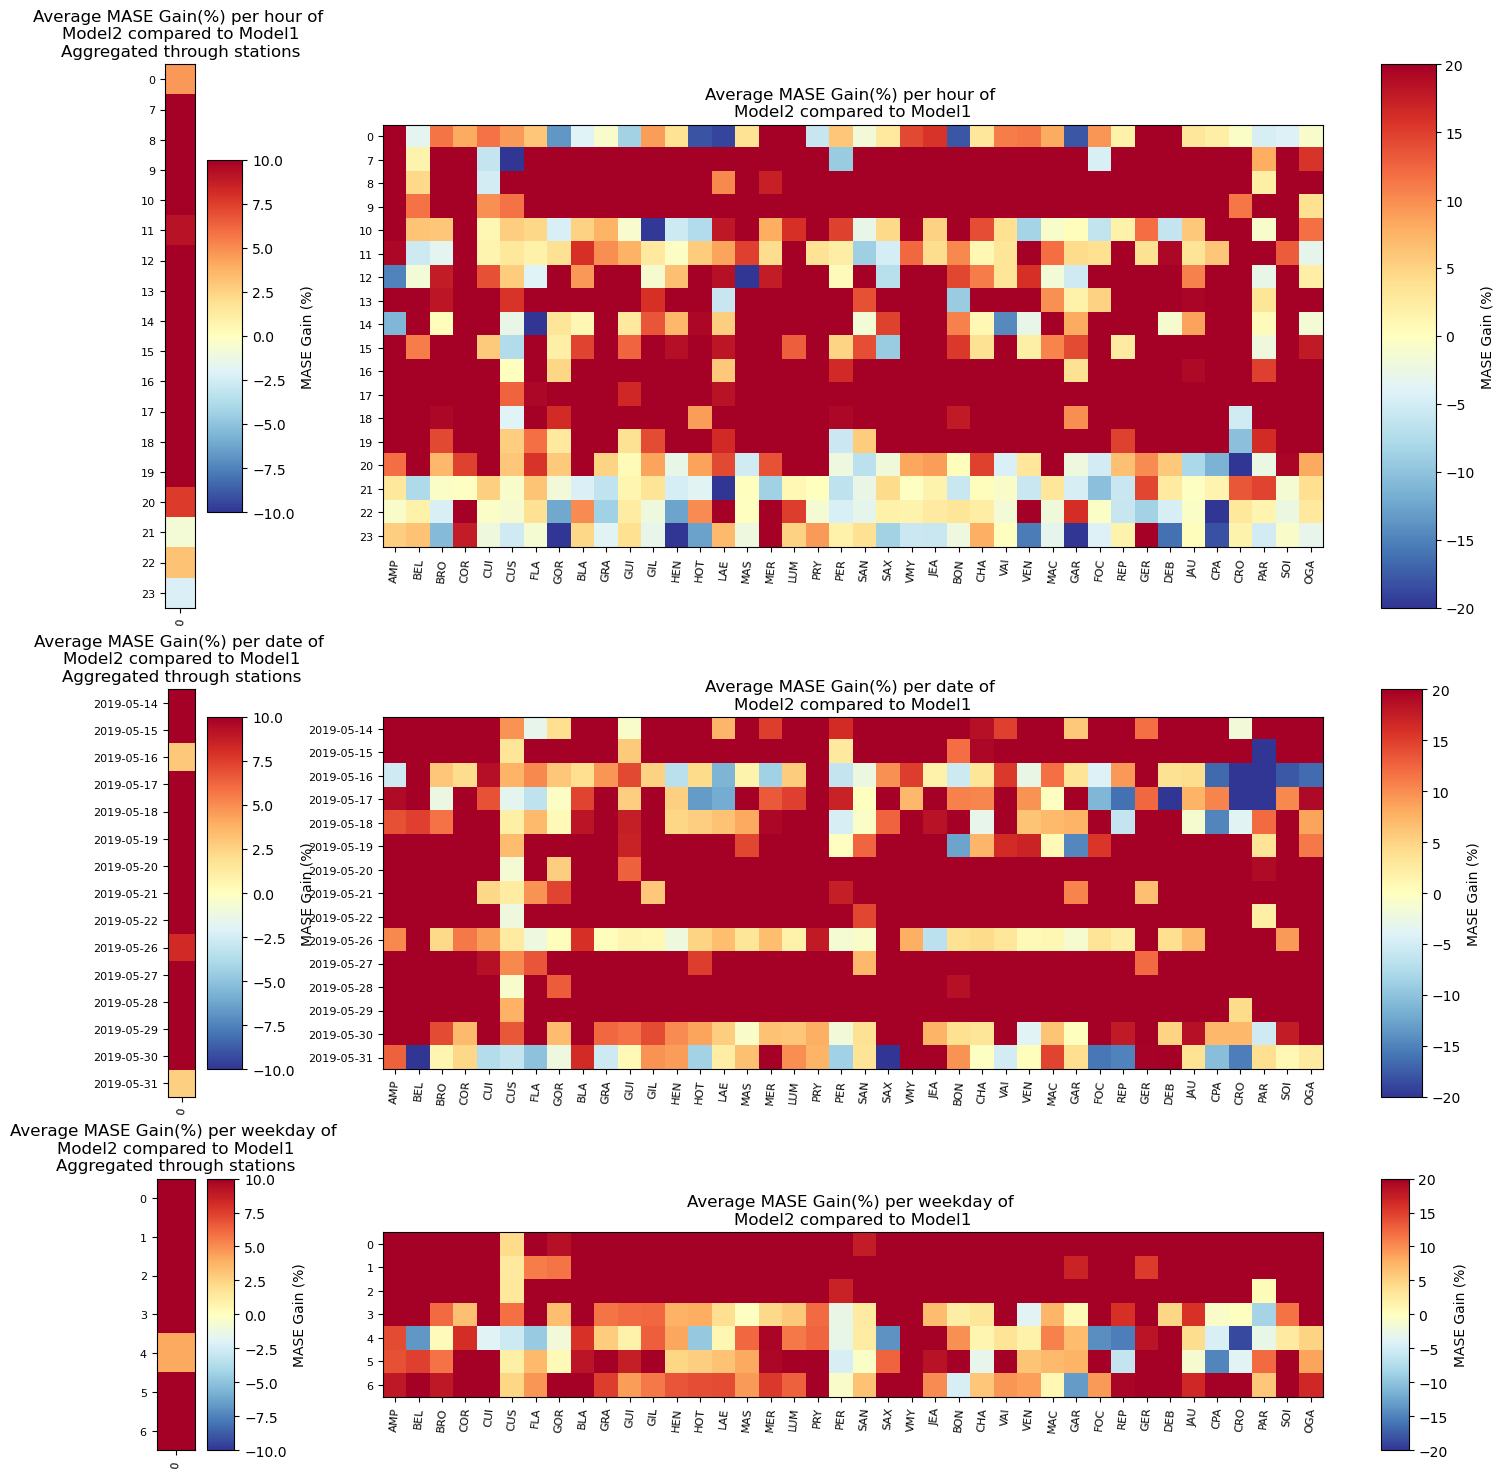

In [12]:
# Load Trained Model with no fine-tuning:
modification = {'shuffle':False,
                'data_augmentation' : False,
                }
trainer_init,ds_init,args_init = get_trainer_and_ds_from_saved_trial(trial_id,add_name_id,save_folder,modification)


# Get Pred1,Pred2, TrueValues:
training_mode = 'test'
min_flow = 20

previous,predict1,predict2,real = get_previous_and_prediction(trainer_init,trainer,ds_init,ds,training_mode)
dic_gain,dic_error = get_gain_from_mod1(real,predict1,predict2,previous,min_flow,metrics = ['mse','mae','mape'],acceptable_error= 0,mape_acceptable_error=0)

temporal_aggs = ['hour','date','weekday']
stations = list(ds.spatial_unit)  # ['BEL','PER','PAR','AMP','FOC'] #list(ds1.spatial_unit)

plot_gain_between_models_with_temporal_agg(ds,dic_error,stations,temporal_aggs,training_mode)

In [19]:
from plotting.TS_analysis import plot_TS
import pandas as pd

station = 'AMP'
station_i = list(ds.spatial_unit).index(station)
predict,Y_true,_ = trainer.testing(ds.normalizer, training_mode =training_mode)
predict_init,Y_true,_ = trainer_init.testing(ds_init.normalizer, training_mode =training_mode)
df_time_series = pd.DataFrame({'Prediction_fine_tuned':predict[:,station_i,0].detach().cpu().numpy(),
                               'Prediction_init':predict_init[:,station_i,0].detach().cpu().numpy(),
                               'Y_true': Y_true[:,station_i,0].detach().cpu().numpy()
                               },index = ds.tensor_limits_keeper.df_verif_test.iloc[:,-1].values)
plot_TS(df_time_series,width=1600,height=400,bool_show=True) #,title=f"Comparaison before/after fine tuning")

Loading BokehJS ...

figure(id='p1165', ...)

# UQ

In [39]:
#Trained Model with Subway-in / Subway-out 
if True:
    save_folder2 = 'K_fold_validation/training_with_HP_tuning/re_validation'
    add_name_id2 = 'concat_early'
    trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' 
    #trainer2,ds2,args2 = get_trainer_and_ds_from_saved_trial(trial_id2,add_name_id2,save_folder2,modification)


modification = {'loss_function_type':'quantile'}
fold_name = 'complete_dataset'
#args,_ = load_configuration(trial_id1,load_config=True)
args = load_args_of_a_specific_trial(trial_id2,add_name_id2,save_folder2,fold_name)
ds,args,_,_,_ =  get_ds(args_init=args,modification = modification,fold_to_evaluate=[args.K_fold-1])
model = load_model(ds, args)


# Load Trained Weights 
model_param = torch.load(f"{current_path}/{SAVE_DIRECTORY}/{save_folder2}/best_models/{trial_id2}{add_name_id2}_f{fold_name}.pkl")
weight_without_output = {k: v for k, v in model_param['state_dict'].items() if not 'core_model.output' in k}
output_weights = {k: v for k, v in model_param['state_dict'].items() if 'core_model.output' in k}

output_weights_to_fill =  {k: v for k, v in model.state_dict().items() if 'core_model.output' in k}
model.load_state_dict(weight_without_output, strict=False)

>>>>Model: STGCN; K_fold = 6; Loss function: quantile 
Invalid dates within this fold: 776



Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
vision_input_type POIs
vision_model_name VariableSelectionNetwork
2821 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by dupplication but not modified
calendar_hour data augmented by dupplication but not modified
Train/Target size:  torch.Size([5642, 40, 7]) torch.Size([5642, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 5642 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
vision_input_type POIs
vision_model_name VariableSelectionNetwork
1059 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by dupplication but not modif

_IncompatibleKeys(missing_keys=['core_model.output.tmp_conv1.align.align_conv.weight', 'core_model.output.tmp_conv1.align.align_conv.bias', 'core_model.output.tmp_conv1.causal_conv.weight', 'core_model.output.tmp_conv1.causal_conv.bias', 'core_model.output.fc1.weight', 'core_model.output.fc1.bias', 'core_model.output.fc2.weight', 'core_model.output.fc2.bias', 'core_model.output.tc1_ln.weight', 'core_model.output.tc1_ln.bias'], unexpected_keys=[])

## Fly-by transit:
#### Concept existants:
- Stop-Less Autonomous Modular (SLAM) (testé à dubai en 2018) : micro bus qui peuvent se concatener si besoin (opour en faire des plus gros), et qui sont indépendant également si beson . Permet de distribuer correctement les usagers selon leur destinations. A Dubai: 6 seats et 4 debout par mini bus (capacity 10).
L'idée c'est d'arrêter de faire des stops. 
- AMB aussi à produit des prototype du henre.

Limite dans le cas d'utilisation 'massive': pas inclusif, les vieux peuvent pas aler d'un module à un autre. Même pour marcher entre deux module c'est pas incroyable. Puis dans tout les cas on a jamais 2 passagers qui ont les mêmes OD. 
#### Leur proposition: 
proposer leur propre model mais en préservant la dimension 'transport public'. 
Propose de décomposer en tout petit moduel, pour 1 a 2 personne. Pouvant se mettre par exemple en platoon etc.
## Question : 
- que faire dnas le cas où bu va d'un point A à un point B, dont la majorité de ses usagers font ce trajet ?
- Enormement de 'sous module': technologie embarquée, seat à laver après chaque utilisation/journée, réparation etc... finalement pas de coût de driver mais énormément d'autres coûts, s'assurer en permanance de la sécurité de chaque unité (high speed, donc dangereux), les réparations etc...
- Utilisation de la capacité 'urbaine': acutellement beaucoup de congestion. ça ne devrait pas les aider, d'autant plus que si on permet à tout le monde de se déplacer ça va encourager des 'micro' déplacement', qui prennent de la place sur le réseau (contrairement à des mobilités douces types vélo, ou contrairement a des gros system de transport type metro / bus grande capacité).
- C'est moins cher que le Taxi par personne transporté. Mais on ne veut pas un taxi par personne.  comparaiosn avec un model non souhaitable.
- Compare le prix avec une voiture éléctrique. Mais la on parle d'un truc autonome.
- Surement des moment et endroit où quand la demande est importante, il y a aura des centaines de Trailers qui devront se déplacer au même endroit, et ça va générer d'énorme problème logistique.


In [ ]:
print(model.state_dict().core_model.output.fc2.weight.size())
print(model_param['state_dict'].core_model.output.fc2.weight.size()) #.bias .tc1_ln_weight .tc1_ln.bias

In [45]:
print('output_weights_to_fill')
for key in output_weights_to_fill.keys():
    print(key)

print('former weights')
for key in output_weights.keys():
    print(key)

output_weights_to_fill
core_model.output.tmp_conv1.align.align_conv.weight
core_model.output.tmp_conv1.align.align_conv.bias
core_model.output.tmp_conv1.causal_conv.weight
core_model.output.tmp_conv1.causal_conv.bias
core_model.output.fc1.weight
core_model.output.fc1.bias
core_model.output.fc2.weight
core_model.output.fc2.bias
core_model.output.tc1_ln.weight
core_model.output.tc1_ln.bias
former weights
core_model.output.tmp_conv1.align.align_conv.weight
core_model.output.tmp_conv1.align.align_conv.bias
core_model.output.tmp_conv1.causal_conv.weight
core_model.output.tmp_conv1.causal_conv.bias
core_model.output.fc1.weight
core_model.output.fc1.bias
core_model.output.fc2.weight
core_model.output.fc2.bias
core_model.output.tc1_ln.weight
core_model.output.tc1_ln.bias
